In [1]:
import collections
import math
import os
import errno
import random
import zipfile
import urllib

import numpy as np
import tensorflow as tf

In [2]:
data_dir = "./word2vec_data/words"
data_url = "http://mattmahoney.net/dc/text8.zip"

In [3]:
def fetch_words_data(url=data_url, words_data=data_dir):
    os.makedirs(words_data, exist_ok=True)
    
    zip_path = os.path.join(words_data, "words.zip")
    
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    return data.decode("ascii").split()

In [4]:
words = fetch_words_data()

In [5]:
words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [6]:
my_counter = collections.Counter(words)

## Top 10 words

In [7]:
my_counter.most_common(10)

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

In [8]:
def create_counts(vocab_size=50_000):
    vocab = [] + my_counter.most_common(vocab_size)
    vocab = np.array([word for word, _ in vocab])
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word, 0) for word in words])
    
    return data, vocab

In [9]:
data, vocabulary = create_counts()

In [10]:
# copy from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [11]:
# constants

batch_size = 128
embedding_size = 150
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100

In [12]:
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
valid_examples

array([36, 46,  8, 59, 97, 51, 38, 56, 44, 57, 60, 52,  2, 86, 29, 65])

In [13]:
num_sampled = 64
learning_rate = 0.01
vocabulary_size = 50_000

In [14]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [15]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], minval=-1.0, maxval=1.0)

In [16]:
embeddings = tf.Variable(init_embeds)

In [17]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [18]:
nce_weights = tf.Variable(
    tf.truncated_normal(
        [vocabulary_size, embedding_size],
        stddev=1.0 / np.sqrt(embedding_size)
    )
)

nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [19]:
loss = tf.reduce_mean(tf.nn.nce_loss(
    nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size
))

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [21]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [22]:
data_index = 0

In [23]:
init = tf.global_variables_initializer()

In [24]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [25]:
num_steps = 10_000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_input, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {
            train_inputs: batch_input,
            train_labels: batch_labels
        }
        
        _, loss_val = sess.run([train, loss], feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss / 1000
            
            print("Average loss at step ", step, " is: ", average_loss)
            average_loss = 0
        
        final_embeddings = normalized_embeddings.eval()

Average loss at step  0  is:  296.89447021484375
Average loss at step  1000  is:  165.59093478393555
Average loss at step  2000  is:  97.02841551971436
Average loss at step  3000  is:  70.59483995056152
Average loss at step  4000  is:  55.20054937553406
Average loss at step  5000  is:  43.59917421340943
Average loss at step  6000  is:  39.0635094537735
Average loss at step  7000  is:  32.72647767686844
Average loss at step  8000  is:  29.731874580860136
Average loss at step  9000  is:  26.824418635368346


In [26]:
final_embeddings

In [27]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [28]:
plot_only = 500

In [29]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only, :])

In [30]:
labels = [vocabulary[i] for i in range(plot_only)]

In [31]:
low_dim_embed.shape

(500, 2)

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )

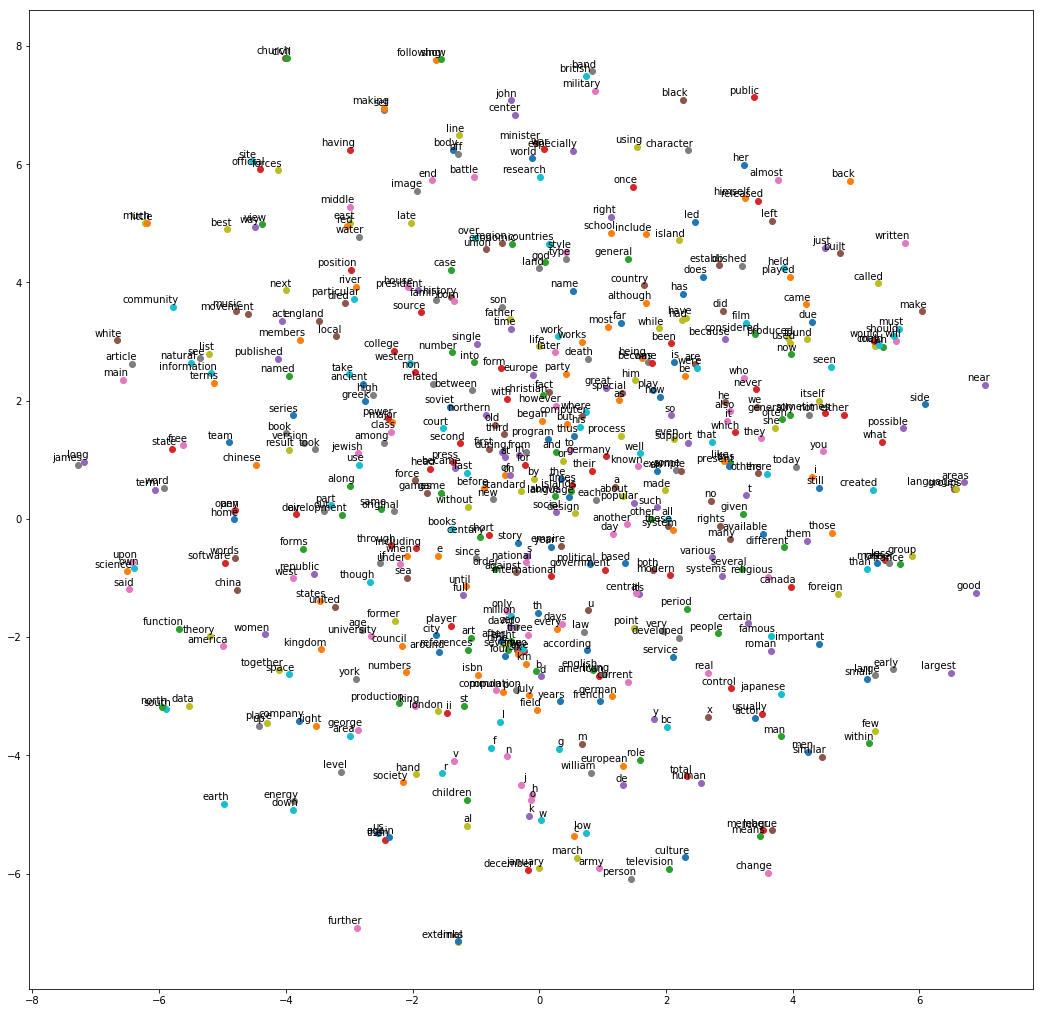

In [34]:
plot_with_labels(low_dim_embed, labels)